<a href="https://colab.research.google.com/github/chenyu313/TensorFlow-note/blob/main/TensorFlow%E5%86%B3%E7%AD%96%E6%A3%AE%E6%9E%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用TensorFlow决策森林构建、训练和评估模型
决策森林(DF)是一系列用于监督分类、回归和排序的机器学习算法。顾名思义，DF使用决策树作为构建块。目前，两种最流行的DF训练算法是随机森林和梯度增强决策树。

TensorFlow Decision Forests (TF-DF)是一个用于训练、评估、解释和推理决策森林模型的库。


## 安装TensorFlow决策森林

In [ ]:
!pip install tensorflow_decision_forests
# 需要Wurlitzer在Colabs中显示详细的训练日志(当在模型构造器中使用verbose=2时)。
!pip install wurlitzer

In [2]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [3]:
# 检查TensorFlow决策森林的版本
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.3.0


## 训练随机森林模型
训练、评估、分析和导出一个基于Palmer’s Penguins数据集训练的二元分类随机森林。

注:数据集导出为csv文件，未进行预处理:library(palmerpenguins)；write.csv(penguins，file="penguins.csv"， quote=F, row.names=F)。

### 加载数据集并将其转换为tf.Dataset
这个数据集非常小(300个示例)，并存储为.csv类文件。因此，使用Pandas来加载它。

让我们将数据集组装成一个csv文件(即添加标题)，并加载它:

这是一个帕尔马企鹅数据集，其中包含三种企鹅物种的测量值：
* Chinstrap
* Gentoo
* Adelie

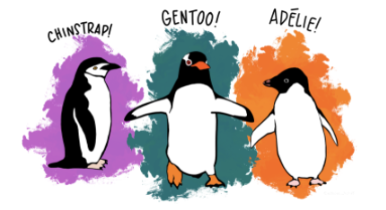

In [15]:
# 下载数据集
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# 将数据集加载到Pandas Dataframe
dataset_df = pd.read_csv("/tmp/penguins.csv")

# 显示前3个示例
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


数据集包含数值特征(例如bill_depth_mm)、分类特征(例如island)和缺失特征的混合。TF-DF原生支持所有这些特征类型(与基于神经网络的模型不同)，因此不需要以one-hot编码、规范化或额外的is_present特征的形式进行预处理。

标签有点不同:Keras指标需要整数。标签(物种)存储为字符串，因此让我们将其转换为整数。

In [5]:
# 将分类标签编码为整数
#
# 细节:
# 如果分类标签表示为字符串，这个阶段是必要的，因为Keras需要整数分类标签.
# 当使用' pd_dataframe_to_tf_dataset '(见下文)时，可以跳过此步骤

# 标签列名称
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


接下来将数据集分成训练和测试两部分:

In [6]:
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

250 examples in training, 94 examples for testing.


最后，将pandas数据框(pd.Dataframe)转换为tensorflow数据集(tf.data.Dataset):

In [7]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

注意:回想一下pd_dataframe_to_tf_dataset在必要时将字符串标签转换为整数。
如果你想自己创建tf.data.Dataset，有几件事要记住:
* 该学习算法使用单历元数据集，无需随机打乱。
* 批处理大小不会影响训练算法，但较小的值可能会减慢读取数据集的速度。

### 使用默认超参数训练模型


可以在不指定任何超参数的情况下训练第一个 CART（分类树和回归树）模型。这是因为 tfdf.keras.CartModel 函数提供良好的默认超参数值。在本课程的后面部分，您将详细了解此类模型的工作原理。

In [18]:

model = tfdf.keras.CartModel()
model.fit(train_ds)

Use /tmp/tmpea3unavs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.204938. Found 250 examples.
Training model...
Model trained in 0:00:00.022208
Compiling model...
Model compiled.


上述对 tfdf.keras.CartModel 的调用没有指定用作输入特征的列。因此，系统会使用训练集中的每一列。该调用也未指定输入特征的语义（例如，数值、分类、文本）。因此，tfdf.keras.CartModel 会自动推断语义。

调用 tfdf.model_plotter.plot_model_in_colab 以显示生成的决策树：

In [19]:
tfdf.model_plotter.plot_model_in_colab(model, max_depth=10)

## 评价模型
用测试集评价模型

【说明】：模型的训练和测试准确率，由于决策树没有损失的概念，因此 Keras evaluate 函数返回的“损失”始终为零。



In [21]:
model.compile("accuracy")
print("Train evaluation: ", model.evaluate(train_ds, return_dict=True))


print("Test evaluation: ", model.evaluate(test_ds, return_dict=True))

1/1 [==============================] - 0s 157ms/step - loss: 0.0000e+00 - accuracy: 0.9600


Train evaluation:  {'loss': 0.0, 'accuracy': 0.9599999785423279}
1/1 [==============================] - 0s 100ms/step - loss: 0.0000e+00 - accuracy: 0.9787
Test evaluation:  {'loss': 0.0, 'accuracy': 0.978723406791687}


将模型导出为SavedModel格式以便以后重用，例如TensorFlow Serving。

In [23]:
model.save("/tmp/my_saved_model")

##  Keras 调谐器优化超参数
以下代码会优化两个参数：
* 条件节点中的示例数下限 (min_examples)
* 用于剪枝验证的训练数据集所占的比率 (validation_ratio)

由于我们不知道这些参数的最佳值，因此我们提供各种选项供调谐器尝试。我们分别为 min_examples 和 validation_ratio 选择了四个可能的值。增加候选超参数值的数量会增加训练更好模型的几率，但也会增加训练时间。

In [22]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


In [24]:
import keras_tuner as kt

def build_model(hp):
  model = tfdf.keras.CartModel(
      min_examples=hp.Choice("min_examples",
          # 为“min_examples”超参数尝试四个可能的值
          # Min_examples=10会限制决策树的增长，
          # 而min_examples=1将导致更深入的决策树。
         [1, 2, 5, 10]),
      validation_ratio=hp.Choice("validation_ratio",
         # “validation_ratio”超参数的三个可能值
         [0.0, 0.05, 0.10]),
      )
  model.compile("accuracy")
  return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    directory="/tmp/tuner",
    project_name="tune_cart")

tuner.search(x=train_ds, validation_data=test_ds)
best_model = tuner.get_best_models()[0]

print("Best hyperparameters: ", tuner.get_best_hyperparameters()[0].values)

Trial 10 Complete [00h 00m 01s]
val_accuracy: 0.978723406791687

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 14s
Use /tmp/tmpdgrhf6d8 as temporary training directory
Best hyperparameters:  {'min_examples': 5, 'validation_ratio': 0.0}


使用这些优化的超参数重新训练和评估模型：

In [25]:
model = tfdf.keras.CartModel(min_examples=2, validation_ratio=0.0)
model.fit(train_ds)

model.compile("accuracy")
print("Test evaluation: ", model.evaluate(test_ds, return_dict=True))
# >> Test evaluation:  {'loss': 0.0, 'accuracy': 1.0}

Use /tmp/tmprffgdg52 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.221963. Found 250 examples.
Training model...
Model trained in 0:00:00.031410
Compiling model...
Model compiled.
1/1 [==============================] - 0s 167ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test evaluation:  {'loss': 0.0, 'accuracy': 1.0}


In [26]:
# 可视化
tfdf.model_plotter.plot_model_in_colab(model, max_depth=10)

正如新的超参数值所预期的那样，此决策树比之前更深，原因如下：

* 示例数下限已减少（从 5 个减少到 2 个）。
* 验证剪枝已停用 (validation_ratio=0.0)，导致有更多可用的训练示例且不剪枝。

## 参考
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#model_structure_and_feature_importance